In [34]:
import numpy as np
import matplotlib.pyplot as pyplot
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation


Vmax = 80
L = 11
Dt = 0.001
rhomax = 250
nx = 51
dx = L/(nx-1)
x = np.linspace(0,L,nx)
rho0 = np.ones(nx)*10
rho0[10:20] = 50
print(rho0)
nt = int(6/60/Dt)+1
rho = np.zeros((nt,nx))
rho[0]=rho0
v = np.zeros((nt,nx))
v[0]= Vmax*(1-rho[0][:]/rhomax)
vm = np.zeros(nt)

def F(x):
    return Vmax*x(1-x/rhomax)

for n in range(1, nt):
    rhon=rho.copy()
    rho[n][1:] = rho[n-1][1:]-Dt/dx*Vmax*((rho[n-1][1:]*(1-rho[n-1][1:]/rhomax))-(rho[n-1][0:-1])*(1-rho[n-1][0:-1]/rhomax))
    v[n][:] = Vmax*(1-rho[n][:]/rhomax)
    rho[n][0] = 10.0
    vm[n]= np.average(v[n])
v0= min(v[0])/3.6
print(v0)
print(vm[50]/3.6)
print(min(v[100])/3.6)


[ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  50.  50.  50.  50.  50.
  50.  50.  50.  50.  50.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.  10.]
17.7777777778
20.65359539
18.7847168709


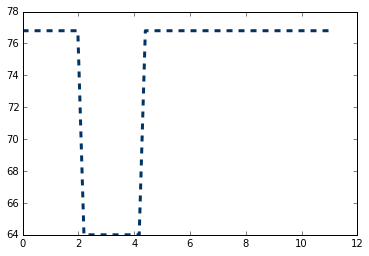

In [30]:
pyplot.plot(x, v[0], color='#003366', ls='--', lw=3)


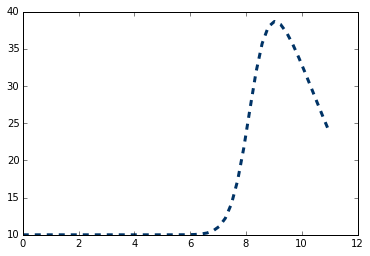

In [31]:

pyplot.plot(x, rho[100], color='#003366', ls='--', lw=3)

In [33]:
import numpy as np
import matplotlib.pyplot as pyplot
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation


Vmax = 136
L = 11
Dt = 0.001
rhomax = 250
nx = 51
dx = L/(nx-1)
print(dx)
x = np.linspace(0,L,nx)
rho0 = np.ones(nx)*20
rho0[10:20] = 50
print(rho0)
nt = int(6/60/Dt)+1
rho = np.zeros((nt,nx))
rho[0]=rho0
v = np.zeros((nt,nx))
v[0]= Vmax*(1-rho[0][:]/rhomax)
vm = np.zeros(nt)

for n in range(1, nt):
    rhon=rho.copy()    
    rho[n][1:] = rho[n-1][1:]-Dt/dx*Vmax*((rho[n-1][1:]*(1-rho[n-1][1:]/rhomax))-(rho[n-1][0:-1])*(1-rho[n-1][0:-1]/rhomax))
    v[n][:] = Vmax*(1-rho[n][:]/rhomax)
    rho[n][0] = 20.0
    vm[n]= np.average(v[n])
v0= min(v[0])/3.6
print(v0)
print(vm[50]/3.6)
print(min(v[50])/3.6)


0.22
[ 20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  50.  50.  50.  50.  50.
  50.  50.  50.  50.  50.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.
  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.
  20.  20.  20.  20.  20.  20.]
30.2222222222
33.9314774502
30.9864026806
